In [1]:
import sqlite3
import os

from pathlib import Path

# Obtain the execution path
actual_path = Path.cwd()

# Obtain the parent directory
father_dir = actual_path.parent
la_liga_dataset = os.path.join(father_dir, "laliga.sqlite")
print(la_liga_dataset)

C:\Users\rpieres\Documents\GitHub\la-quiniela\laliga.sqlite


In [2]:
# Connect to the database
conexion = sqlite3.connect(la_liga_dataset)

# Create cursor to be able to ask data
cursor = conexion.cursor()

# Select the Matches table
cursor.execute("SELECT * FROM Matches")  # cambia 'usuarios' por tu tabla

# Obtain all the data
filas = cursor.fetchall()

# Close the connection
conexion.close()

In [3]:
import pandas as pd
columns = ["season", "division", "matchday", "date", "time",
            "home_team", "away_team", "score"]
df = pd.DataFrame(filas, columns=columns)

In [4]:
df

,season,division,matchday,date,time,home_team,away_team,score
0,1928-1929,1,1,2/10/29,None,Arenas Club,Athletic Madrid,2:3
1,1928-1929,1,1,2/10/29,None,Espanyol,Real Unión,3:2
2,1928-1929,1,1,2/10/29,None,Real Madrid,Catalunya,5:0
3,1928-1929,1,1,2/10/29,None,Donostia,Athletic,1:1
4,1928-1929,1,1,2/12/29,None,Racing,Barcelona,0:2
...,...,...,...,...,...,...,...,...
48775,2021-2022,2,42,5/29/22,None,Real Oviedo,UD Ibiza,None
48776,2021-2022,2,42,5/29/22,None,Real Sociedad B,Real Zaragoza,None
48777,2021-2022,2,42,5/29/22,None,Sporting Gijón,UD Las Palmas,None
48778,2021-2022,2,42,5/29/22,None,CD Tenerife,FC Cartagena,None


In [5]:
df = df.dropna(subset=["score"])
df_first = df[df["division"] == 1].copy()

In [6]:
df_first[["local_score", "visit_score"]] = df_first["score"].str.split(":", expand=True).astype(int)

In [7]:
df_first

,season,division,matchday,date,time,home_team,away_team,score,local_score,visit_score
0,1928-1929,1,1,2/10/29,None,Arenas Club,Athletic Madrid,2:3,2,3
1,1928-1929,1,1,2/10/29,None,Espanyol,Real Unión,3:2,3,2
2,1928-1929,1,1,2/10/29,None,Real Madrid,Catalunya,5:0,5,0
3,1928-1929,1,1,2/10/29,None,Donostia,Athletic,1:1,1,1
4,1928-1929,1,1,2/12/29,None,Racing,Barcelona,0:2,0,2
...,...,...,...,...,...,...,...,...,...,...
47963,2021-2022,1,3,8/28/21,10:00 PM,Real Betis,Real Madrid,0:1,0,1
47964,2021-2022,1,3,8/29/21,5:00 PM,Barcelona,Getafe,2:1,2,1
47965,2021-2022,1,3,8/29/21,7:30 PM,Cádiz CF,CA Osasuna,2:3,2,3
47966,2021-2022,1,3,8/29/21,7:30 PM,Rayo Vallecano,Granada CF,4:0,4,0


In [8]:
goals_done_being_local = df_first.groupby("home_team")["local_score"].sum()
goals_done_being_visitor = df_first.groupby("away_team")["visit_score"].sum()

goals_received_being_local = df_first.groupby("home_team")["visit_score"].sum()
goals_received_being_visitor = df_first.groupby("away_team")["local_score"].sum()

In [9]:
total_goals_done = goals_done_being_local.add(goals_done_being_visitor, fill_value=0).astype(int)
total_goals_received = goals_received_being_local.add(goals_received_being_visitor, fill_value=0).astype(int)

In [10]:
df_total = pd.concat(
    [total_goals_done, total_goals_received], axis=1
).fillna(0).astype(int)

In [11]:
df_total.columns = ["total_goals_done", "total_goals_received"]
df_total = df_total.reset_index().rename(columns={"home_team": "team"})

In [12]:
df_total

,team,total_goals_done,total_goals_received
0,AD Almería,72,116
1,Alavés,608,852
2,Albacete,320,410
3,Arenas Club,227,308
4,Ath. Aviación,113,65
...,...,...,...
63,UD Salamanca,425,581
64,UE Lleida,29,48
65,Valencia,4615,3649
66,Villarreal,1123,986


<Axes: title={'center': 'Top 10 teams with more goals received'}, xlabel='team'>

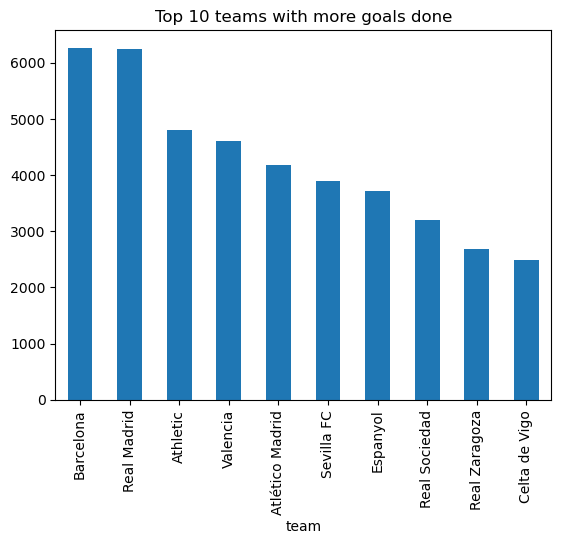

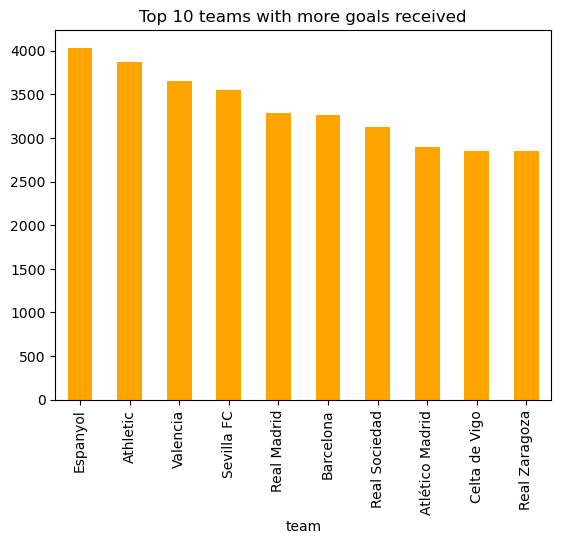

In [13]:
df_total.nlargest(10, "total_goals_done").plot(
    x="team", y="total_goals_done", kind="bar", title="Top 10 teams with more goals done", legend=False
)

df_total.nlargest(10, "total_goals_received").plot(
    x="team", y="total_goals_received", kind="bar", title="Top 10 teams with more goals received", color="orange", legend=False
)

In [17]:
df_first["goal_diff"] = abs(df_first["local_score"] - df_first["visit_score"])
df_first.sort_values(by="goal_diff", ascending=False).head(10)

,season,division,matchday,date,time,home_team,away_team,score,local_score,visit_score,goal_diff
225,1930-1931,1,10,2/8/31,None,Athletic,Barcelona,12:1,12,1,11
1168,1941-1942,1,15,1/11/42,None,Athletic,Celta de Vigo,10:0,10,0,10
936,1940-1941,1,1,9/29/40,None,Sevilla FC,Barcelona,11:1,11,1,10
1071,1941-1942,1,1,9/28/41,None,Sevilla FC,Real Oviedo,10:0,10,0,10
2787,1950-1951,1,11,11/19/50,None,Athletic,Lérida,10:0,10,0,10
4745,1958-1959,1,15,12/28/58,None,Athletic,Real Gijón,9:0,9,0,9
2969,1951-1952,1,3,9/23/51,None,Athletic,Real Zaragoza,10:1,10,1,9
2715,1950-1951,1,2,9/17/50,None,CD Málaga,Lérida,9:0,9,0,9
4750,1958-1959,1,16,1/4/59,None,Real Madrid,UD Las Palmas,10:1,10,1,9
3911,1955-1956,1,1,9/11/55,None,Atlético Madrid,Hércules CF,9:0,9,0,9
